In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)

Project root: /shared/crollo/faers-radar


In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from faers_signals.config import WAREHOUSE_DB_PATH
from faers_signals.emergence import (
    EmergenceConfig,
    compute_global_emergence_scores,
    compute_emergence_scores_for_drug,
)
from faers_signals.embeddings import (
    EmbeddingConfig,
    compute_embedding_novelty,
)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

con = duckdb.connect(str(WAREHOUSE_DB_PATH))
con


## 🔢 Section 1 — Data volume & coverage

In [3]:
# Total deduplicated reports per year-quarter

reports_q = con.execute("""
    SELECT
        year,
        quarter,
        COUNT(DISTINCT primaryid) AS n_reports
    FROM demo_dedup
    GROUP BY year, quarter
    ORDER BY year, quarter
""").fetchdf()

reports_q


,year,quarter,n_reports
0,2019,Q1,339887
1,2019,Q2,356922
2,2019,Q3,373371
3,2019,Q4,351969
4,2020,Q1,384326
5,2020,Q2,351955
6,2020,Q3,350874
7,2020,Q4,349205
8,2021,Q1,383660
9,2021,Q2,400472


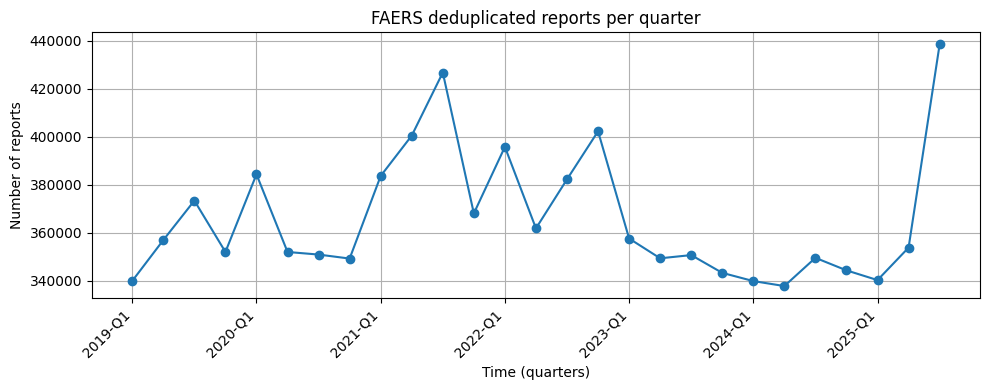

In [4]:
# Plot: number of reports over time (quarterly)

x = np.arange(len(reports_q))
labels = [f"{y}-{q}" for y, q in zip(reports_q["year"], reports_q["quarter"])]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, reports_q["n_reports"], marker="o")
ax.set_title("FAERS deduplicated reports per quarter")
ax.set_xlabel("Time (quarters)")
ax.set_ylabel("Number of reports")
ax.set_xticks(x[::4])
ax.set_xticklabels(labels[::4], rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [5]:
# Unique normalized drugs and PTs overall

unique_counts = con.execute("""
    SELECT
        (SELECT COUNT(DISTINCT drugname_norm) FROM drug_dedup_norm) AS n_drugs,
        (SELECT COUNT(DISTINCT pt) FROM reac_dedup) AS n_pts
""").fetchdf()

unique_counts


,n_drugs,n_pts
0,319515,21586


In [6]:
# Unique drugs and PTs per year

uniq_by_year = con.execute("""
    SELECT
        d.year,
        COUNT(DISTINCT d.drugname_norm) AS n_drugs,
        COUNT(DISTINCT r.pt) AS n_pts
    FROM drug_dedup_norm d
    JOIN reac_dedup r USING (primaryid, year, quarter)
    GROUP BY d.year
    ORDER BY d.year
""").fetchdf()

uniq_by_year


,year,n_drugs,n_pts
0,2019,106723,15084
1,2020,111114,15289
2,2021,99330,15454
3,2022,64895,15597
4,2023,60350,15965
5,2024,53639,16124
6,2025,52316,15950


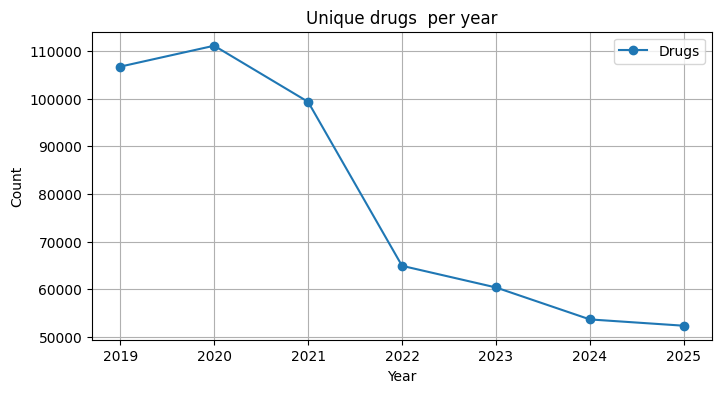

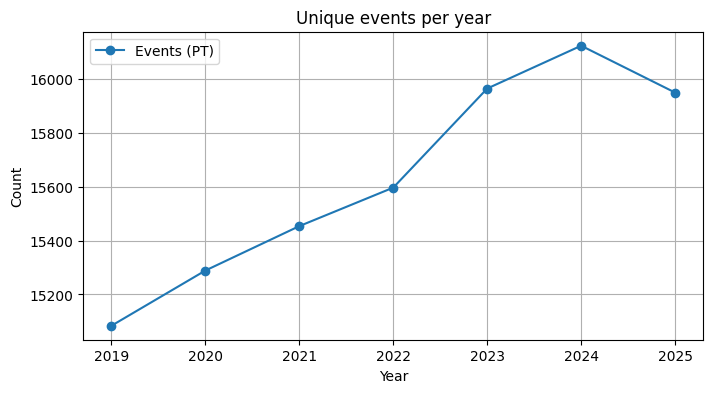

In [9]:
# Plot: unique drugs & PTs per year

fig, ax = plt.subplots()
ax.plot(uniq_by_year["year"], uniq_by_year["n_drugs"], marker="o", label="Drugs")
ax.set_title("Unique drugs  per year")
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(uniq_by_year["year"], uniq_by_year["n_pts"], marker="o", label="Events (PT)")
ax.set_title("Unique events per year")
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.legend()
plt.show()

## 📊 Section 2 — Classical signal landscape

In [11]:
# Aggregate by drug-event pair: total n11 and overall ROR summary
# Here we'll just take the latest ROR per pair as a rough snapshot.

signals_snapshot = con.execute("""
    SELECT *
    FROM (
        SELECT
            drugname_norm,
            pt,
            year,
            quarter,
            ror,
            ror_ci_low,
            ror_ci_high,
            n11,
            ROW_NUMBER() OVER (
                PARTITION BY drugname_norm, pt
                ORDER BY year DESC, quarter DESC
            ) AS rn
        FROM signals_quarterly
    )
    WHERE rn = 1
""").fetchdf()

signals_snapshot.head()


,drugname_norm,pt,year,quarter,ror,ror_ci_low,ror_ci_high,n11,rn
0,.ALPHA.-PYRROLIDINOVALEROTHIOPHENONE,Memory impairment,2025,Q3,32.021024,11.481736,89.302343,4,1
1,".ALPHA.-TOCOPHEROL ACETATE, DL",Cough,2025,Q3,61.325338,24.301591,154.755177,9,1
2,".ALPHA.-TOCOPHEROL ACETATE, DL",Muscle spasms,2025,Q3,120.930358,47.909377,305.246119,9,1
3,".ALPHA.-TOCOPHEROL ACETATE, DL",Oral candidiasis,2025,Q3,409.667602,140.248367,1196.645258,4,1
4,".ALPHA.-TOCOPHEROL SUCCINATE, D",General physical health deterioration,2023,Q3,1528.546450,78.919135,29605.674804,3,1


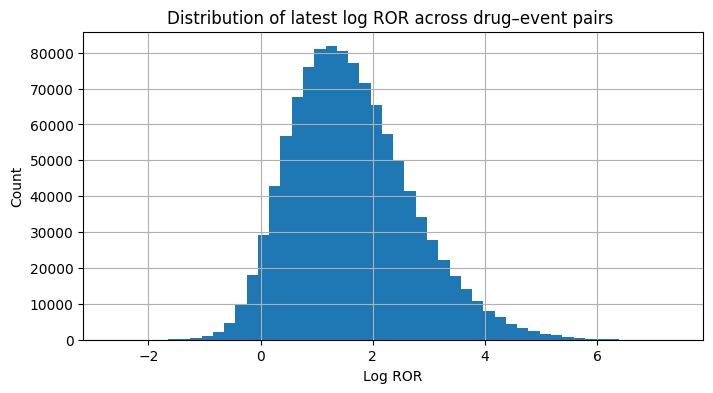

In [31]:
# Plot histogram of ROR (clipped)

ror_vals = signals_snapshot["ror"].replace([np.inf, -np.inf], np.nan).dropna()
ror_vals_clipped = np.clip(ror_vals, 0, 2000)  # avoid crazy tails for visualization

plt.hist(np.log10(ror_vals), bins=50)
plt.title("Distribution of latest log ROR across drug–event pairs ")
plt.xlabel("Log ROR")
plt.ylabel("Count")
#plt.xscale('log')
#plt.yscale('log')
plt.show()

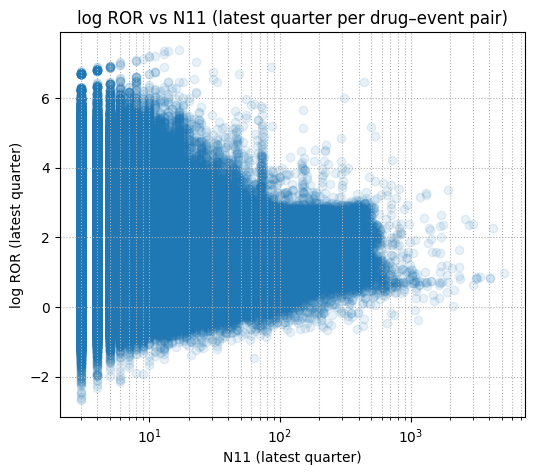

In [37]:
# Scatter: ROR vs support (n11) – log scale for n11

plt.figure(figsize=(6, 5))
plt.scatter(signals_snapshot["n11"], np.log10(signals_snapshot["ror"]), alpha=0.1)
plt.xscale("log")
#plt.ylim(0, 20)
plt.xlabel("N11 (latest quarter)")
plt.ylabel("log ROR (latest quarter)")
plt.title("log ROR vs N11 (latest quarter per drug–event pair)")
plt.grid(True, which="both", ls=":")
plt.show()


## 🕒 Section 3 — Per-drug temporal and novelty summary

In [50]:
drug = "ATORVASTATIN"  # change as needed

In [51]:
# Get latest ROR per event for this drug

signals_drug_latest = con.execute("""
    SELECT *
    FROM (
        SELECT
            pt,
            year,
            quarter,
            ror,
            ror_ci_low,
            ror_ci_high,
            n11,
            ROW_NUMBER() OVER (
                PARTITION BY pt
                ORDER BY year DESC, quarter DESC
            ) AS rn
        FROM signals_quarterly
        WHERE drugname_norm = ?
    )
    WHERE rn = 1
""", [drug]).fetchdf()

signals_drug_latest.sort_values("n11", ascending=False).head(15)


,pt,year,quarter,ror,ror_ci_low,ror_ci_high,n11,rn
1303,Myalgia,2025,Q3,11.745183,9.849110,14.006274,140,1
61,Fatigue,2025,Q3,1.561204,1.295434,1.881501,119,1
882,Asthenia,2025,Q3,2.799152,2.267298,3.455766,92,1
574,Headache,2025,Q3,1.766566,1.431434,2.180160,92,1
1482,Drug ineffective,2025,Q3,0.926675,0.745157,1.152411,85,1
14,Arthralgia,2025,Q3,1.739346,1.383729,2.186356,77,1
1483,Drug-induced liver injury,2025,Q3,15.121174,11.913704,19.192176,74,1
834,Nausea,2025,Q3,1.052087,0.832335,1.329858,73,1
336,Off label use,2025,Q3,0.615018,0.485898,0.778451,72,1
822,Medication error,2025,Q3,17.748808,13.880053,22.695893,70,1


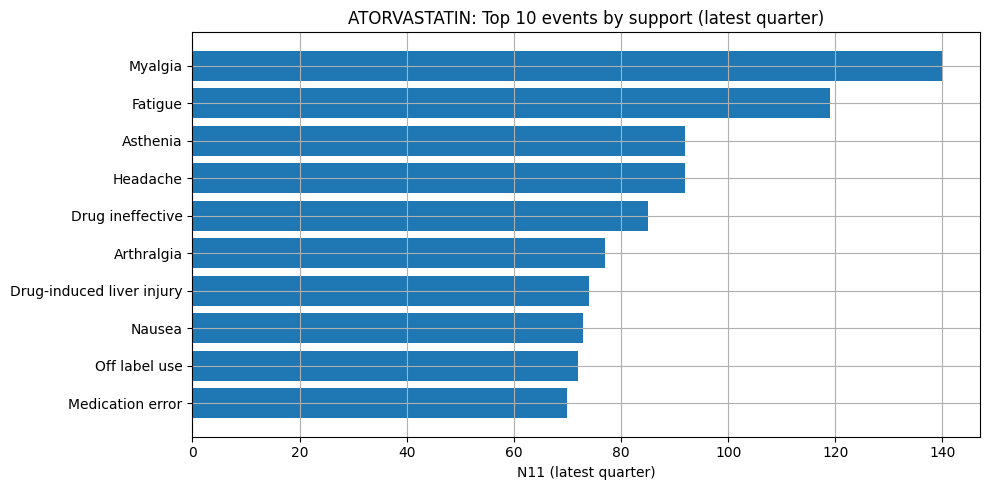

In [52]:
# Plot: Top 15 events by N11, with their RORs

topN = 10
top_drug = signals_drug_latest.sort_values("n11", ascending=False).head(topN)

fig, ax1 = plt.subplots(figsize=(10, 5))
y_pos = np.arange(len(top_drug))

ax1.barh(y_pos, top_drug["n11"])
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_drug["pt"])
ax1.invert_yaxis()
ax1.set_xlabel("N11 (latest quarter)")
ax1.set_title(f"{drug}: Top {topN} events by support (latest quarter)")
plt.tight_layout()
plt.show()

In [53]:
cfg_em = EmergenceConfig(min_points=4, min_n11_latest=5)
em_drug = compute_emergence_scores_for_drug(drug, cfg=cfg_em, con=con)
em_drug.head()

,pt,emergence_z,slope_log_ror,latest_ror,latest_ror_ci_low,latest_n11,n_points
0,Spinal stenosis,4.403801,0.427500,24.455520,11.059970,6,5
1,Anosmia,3.953809,0.612097,8.377131,4.383118,9,4
2,Diabetic ketoacidosis,3.205833,0.209939,9.657188,5.594073,13,9
3,Cardiac failure acute,2.854421,0.565851,31.625358,15.014293,7,7
4,Therapeutic product effect incomplete,2.757224,0.487545,3.361093,2.343964,30,25


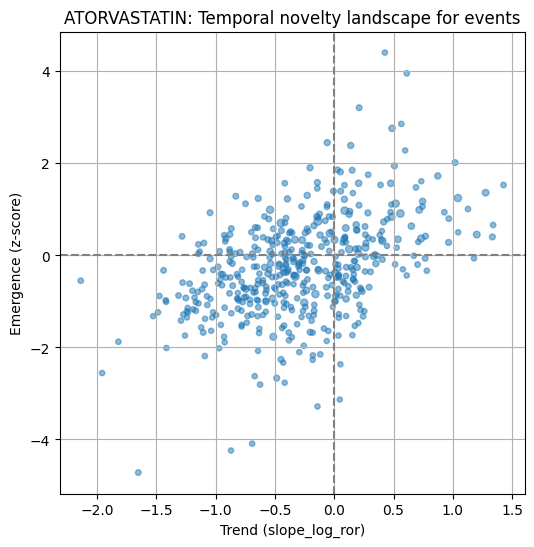

In [54]:
# Plot: emergence_z vs slope_log_ror (scatter), size = latest_n11

plt.figure(figsize=(6, 6))
sizes = 10 + 2 * np.sqrt(em_drug["latest_n11"].clip(lower=1))

plt.scatter(
    em_drug["slope_log_ror"],
    em_drug["emergence_z"],
    s=sizes,
    alpha=0.5,
)
plt.axvline(0, color="gray", linestyle="--")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Trend (slope_log_ror)")
plt.ylabel("Emergence (z-score)")
plt.title(f"{drug}: Temporal novelty landscape for events")
plt.grid(True)
plt.show()

In [55]:
em_drug.sort_values("emergence_z", ascending=False).head(15)

,pt,emergence_z,slope_log_ror,latest_ror,latest_ror_ci_low,latest_n11,n_points
0,Spinal stenosis,4.403801,0.427500,24.455520,11.059970,6,5
1,Anosmia,3.953809,0.612097,8.377131,4.383118,9,4
2,Diabetic ketoacidosis,3.205833,0.209939,9.657188,5.594073,13,9
3,Cardiac failure acute,2.854421,0.565851,31.625358,15.014293,7,7
4,Therapeutic product effect incomplete,2.757224,0.487545,3.361093,2.343964,30,25
5,Coeliac disease,2.447010,-0.058976,32.246496,20.310229,20,4
6,Parkinson's disease,2.384886,0.138819,15.824337,10.204345,21,6
7,Nephropathy,2.278262,0.598239,9.998109,4.261118,5,7
8,White blood cell count increased,2.012866,1.018747,7.688998,4.623634,15,10
9,"Hallucination, visual",1.943422,0.507254,11.459382,7.252016,19,9


## 🌍 Section 4 — Global temporal novelty snapshot

In [56]:
global_em = pd.read_csv("../exports/global_temporal_novelty.csv")

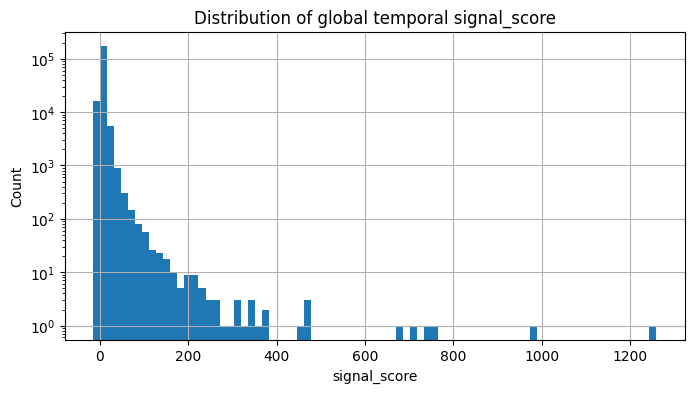

In [68]:
plt.hist(global_em["signal_score"], bins=80)
plt.title("Distribution of global temporal signal_score")
plt.xlabel("signal_score")
plt.ylabel("Count")
plt.yscale('log')
plt.show()

In [69]:
global_filtered = global_em[
    (global_em["latest_ror"] >= 2.0) &
    (global_em["latest_ror_ci_low"] > 1.0) &
    (global_em["latest_n11"] >= 10)
].copy()

global_filtered.sort_values("signal_score", ascending=False).head(20)

,drugname_norm,pt,signal_score,emergence_z,slope_log_ror,latest_ror,latest_ror_ci_low,latest_n11,n_points
4,CLOZAPINE,Investigation noncompliance,708.321371,59.486525,1.362013,6.261905e+03,375.520079,16,4
11,ROXICODONE,Injury,368.622606,11.238662,4.341714,1.908328e+03,1415.717839,221,6
14,PLAN B ONE?STEP,Pregnancy after post coital contraception,340.099769,10.721595,2.746124,1.039000e+05,6201.864519,16,4
17,AFINITOR,Metastases to central nervous system,307.460563,17.021129,3.345290,2.203334e+02,120.746996,13,6
18,COMIRNATY,Eczema,305.451250,21.312723,2.919601,1.344830e+02,90.636461,34,4
32,HYDROCODONE,Injury,224.262117,9.055685,3.476642,1.239402e+03,957.869626,219,4
34,BISOPROLOL FUMARATE,Femoral hernia incarcerated,222.000340,10.850467,1.835710,6.925331e+04,4151.661400,17,4
40,KEPPRA,Pancytopenia,216.331681,81.988490,0.811694,2.480805e+01,14.550128,14,4
44,COMIRNATY,Vertigo,199.240842,11.644833,3.301584,1.770923e+02,121.140062,39,5
45,IMPLANON,Deep vein thrombosis,199.090022,8.409899,3.471403,9.145442e+02,368.648386,12,4


## 🧭 Section 5 — Embedding-based structural novelty overview

In [75]:
cooc = pd.read_csv("../exports/cooccurrence_drug_event.csv")
drug_emb = pd.read_csv("../exports/drug_embeddings.csv")
event_emb = pd.read_csv("../exports/event_embeddings.csv")
novelty_df = pd.read_csv("../exports/embedding_structural_novelty.csv")
combined = pd.read_csv("../exports/combined_temporal_structural_novelty.csv")

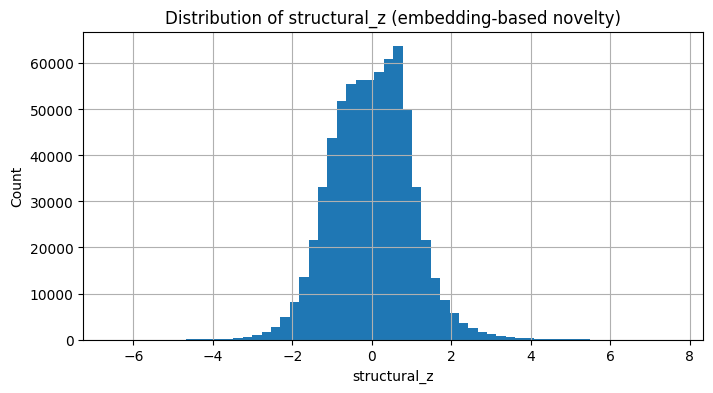

In [76]:
plt.hist(novelty_df["structural_z"], bins=60)
plt.title("Distribution of structural_z (embedding-based novelty)")
plt.xlabel("structural_z")
plt.ylabel("Count")
plt.show()

In [77]:
strong_structural = novelty_df[
    (novelty_df["n11_total"] >= 10) &
    (novelty_df["structural_z"] > 2.0)
].copy()

strong_structural.sort_values("structural_z", ascending=False).head(20)


,drugname_norm,pt,n11_total,observed_log,predicted_log,residual,structural_z
0,OXBRYTA,Sickle cell anaemia with crisis,10916.0,9.298076,0.436800,8.861276,7.632390
1,ELIGARD,Intercepted product preparation error,8435.0,9.040264,0.539511,8.500753,7.280495
2,PAXLOVID,Disease recurrence,20038.0,9.905436,1.560606,8.344830,7.128305
3,NEULASTA,Device adhesion issue,11121.0,9.316680,1.004449,8.312231,7.096486
4,PARAGARD T 380A,Foreign body in reproductive tract,6961.0,8.848222,0.613962,8.234260,7.020381
5,ETHINYL ESTRADIOL\NORELGESTROMIN,Product adhesion issue,2763.0,7.924434,0.209507,7.714927,6.513478
6,GENOTROPIN,Device information output issue,5191.0,8.554874,0.860876,7.693998,6.493050
7,PARAGARD T 380A,Reproductive complication associated with device,3651.0,8.203030,0.535988,7.667043,6.466740
8,PLUVICTO,Ill-defined disorder,3596.0,8.187855,0.522621,7.665235,6.464975
9,SPRAVATO,Dissociation,3071.0,8.030084,0.379546,7.650538,6.450631


In [79]:
combined.sort_values("global_novelty_score", ascending=False).head(20)

,drugname_norm,pt,signal_score,emergence_z,slope_log_ror,latest_ror,latest_ror_ci_low,latest_n11,n_points,structural_z,global_novelty_score
0,EUMOVATE,Pyrexia,1259.480377,93.432873,2.338708,3.175851e+02,53.792267,6,4,0.578844,1988.523601
1,TRIMETAZIDINE,Left ventricular hypertrophy,985.904996,48.736033,1.862860,5.201826e+04,8904.212478,8,4,0.861261,1835.026813
5,TRIMETAZIDINE,Pulmonary valve disease,674.495534,19.546610,2.273648,3.901789e+06,148217.559804,8,4,1.626762,1771.739002
14,PLAN B ONE?STEP,Pregnancy after post coital contraception,340.099769,10.721595,2.746124,1.039000e+05,6201.864519,16,4,3.145462,1409.870718
7,COUMADIN,Sopor,471.610709,15.576601,4.319534,1.105869e+03,421.173108,5,6,1.639785,1244.951045
8,AZITHROMYCIN ANHYDROUS,Deafness neurosensory,465.769039,17.867825,3.724746,1.093942e+03,456.114213,6,4,1.553089,1189.149646
10,PROMETHAZINE HYDROCHLORIDE,Viral test positive,373.679020,35.345812,1.106323,1.412908e+04,5013.751843,7,4,1.828700,1057.025705
9,RELYVRIO,Abdominal discomfort,455.449565,11.322415,5.488734,1.522453e+03,85.742695,6,6,1.140441,974.862774
2,DOXIL,Acute myeloid leukaemia,759.527772,35.924692,3.332449,5.682665e+02,211.215537,5,4,0.259369,956.525513
23,RAPAFLO,Reversible airways obstruction,267.954565,3.544982,4.981377,3.889991e+06,147769.387503,8,7,2.526901,945.049147


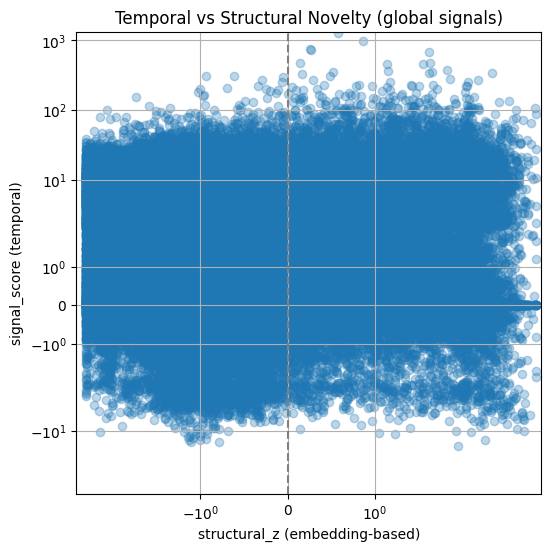

In [86]:
# Scatter: temporal vs structural novelty

subset = combined.dropna(subset=["signal_score", "structural_z"]).copy()

plt.figure(figsize=(6, 6))
plt.scatter(
    subset["structural_z"].clip(-3, 6),
    subset["signal_score"],
    alpha=0.3,
)
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel("structural_z (embedding-based)")
plt.ylabel("signal_score (temporal)")
plt.title("Temporal vs Structural Novelty (global signals)")
plt.xscale('symlog')
plt.yscale('symlog')
plt.grid(True)
plt.show()